# Census income classification with LightGBM

This notebook demonstrates how to use LightGBM to predict the probability of an individual making over $50K a year in annual income. It uses the standard UCI Adult income dataset. To download a copy of this notebook visit [github](https://github.com/slundberg/shap/tree/master/notebooks).

In [1]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import lime
from lime import lime_tabular
# print the JS visualization code to the notebook
shap.initjs()

In [214]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


## Load dataset

In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

## Train the model

In [3]:
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.278029


# Feature Importance

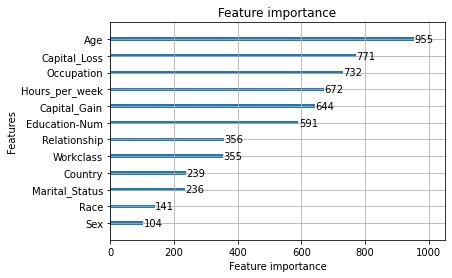

In [4]:
lgb.plot_importance(model)

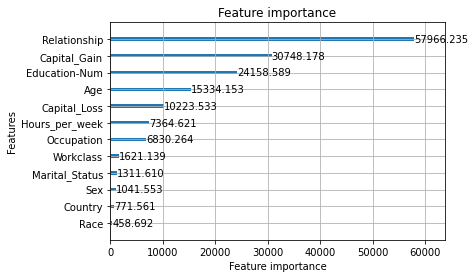

In [5]:
lgb.plot_importance(model,importance_type="gain")

# Lime

In [6]:
def extract_categorical_names(categorical_features, X, X_display):
    categorical_names = {}
    for col_index in categorical_features:
        column_name = X.columns[col_index]
        categorical_names[col_index]=[
            name for i, name in 
            sorted([(v,n) for v, n in zip(X[column_name].drop_duplicates(), X_display[column_name].drop_duplicates())],
               key=lambda tup: tup[0])]
    return categorical_names


categorical_features = [1,3,4, 5, 6,7,11]
categorical_names = extract_categorical_names(categorical_features, X, X_display)

def predict_fn(data):
    return np.array(list(zip(1-model.predict(data),model.predict(data))))


lime_explainer = lime_tabular.LimeTabularExplainer(
    X.to_numpy(), feature_names=X.columns, categorical_features=categorical_features, 
    categorical_names=categorical_names, verbose=True
)


ex = lime_explainer.explain_instance(X.iloc[0], predict_fn, num_features=10)
ex.show_in_notebook(show_table=True, show_all=False)


Intercept 0.19114037076842777
Prediction_local [0.82618383]
Right: 0.005098846263829852


In [7]:
lime_explainer = lime_tabular.LimeTabularExplainer(
    X.to_numpy(), feature_names=X.columns, verbose=True
)

ex = lime_explainer.explain_instance(X.iloc[0], predict_fn, num_features=10)
ex.show_in_notebook(show_table=True, show_all=False)

Intercept 0.19804407775623234
Prediction_local [0.80219337]
Right: 0.005098846263829852


In [8]:
ex = lime_explainer.explain_instance(X.iloc[9], predict_fn, num_features=10)
ex.show_in_notebook(show_table=True, show_all=False)


Intercept 0.15961650436324235
Prediction_local [0.92500629]
Right: 0.9878938011292491


# SHAP

## Explain predictions

Here we use the Tree SHAP implementation integrated into Light GBM to explain the entire dataset (32561 samples).

In [59]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
explanation = explainer(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


### Visualize a single prediction

Note that we use the "display values" data frame so we get nice strings instead of category codes. 

In [10]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_display.iloc[0], link="logit")

In [11]:
shap.force_plot(explainer.expected_value[1], shap_values[1][8], X_display.iloc[8])

In [61]:
shap.force_plot(explanation.base_values[0,1], explanation[0,:,1].values, X_display.iloc[0], link="logit")

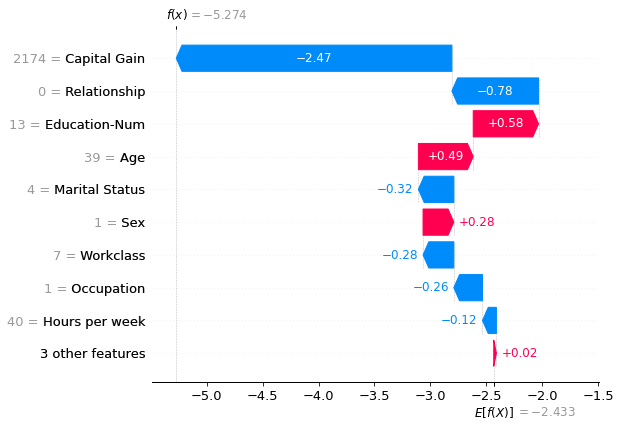

In [13]:
shap.waterfall_plot(explanation[0,:,1])

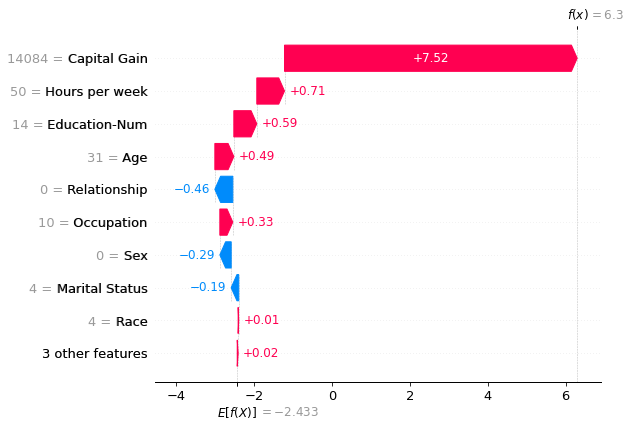

In [14]:
shap.waterfall_plot(explanation[8,:,1])

## SHAP Summary Plot

Rather than use a typical feature importance bar chart, we use a density scatter plot of SHAP values for each feature to identify how much impact each feature has on the model output for individuals in the validation dataset. Features are sorted by the sum of the SHAP value magnitudes across all samples. It is interesting to note that the relationship feature has more total model impact than the captial gain feature, but for those samples where capital gain matters it has more impact than age. In other words, capital gain effects a few predictions by a large amount, while age effects all predictions by a smaller amount.

Note that when the scatter points don't fit on a line they pile up to show density, and the color of each point represents the feature value of that individual.

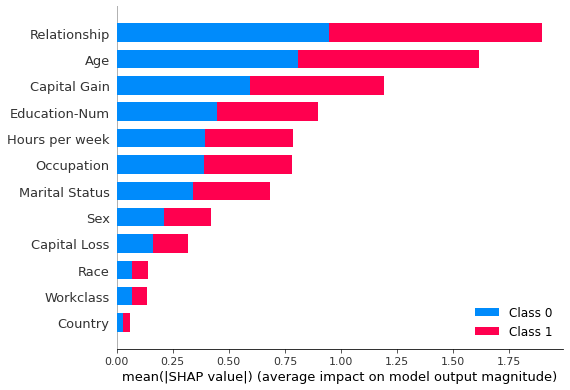

In [15]:
shap.summary_plot(shap_values, X)

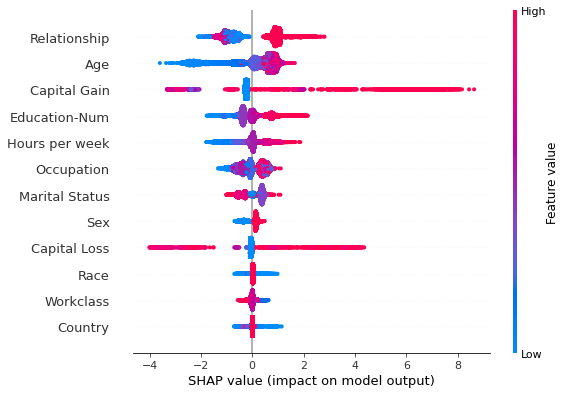

In [16]:
shap.summary_plot(shap_values[1], X)

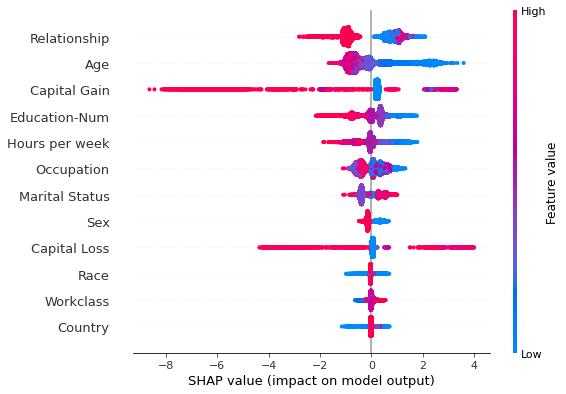

In [17]:
shap.summary_plot(shap_values[0], X)

## SHAP Dependence Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature's value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

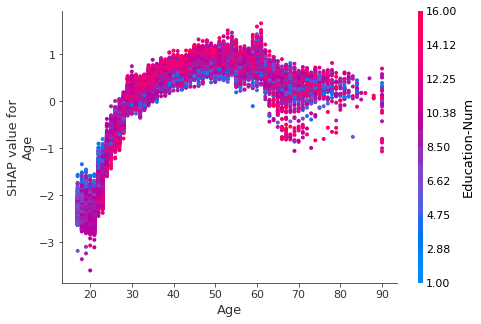

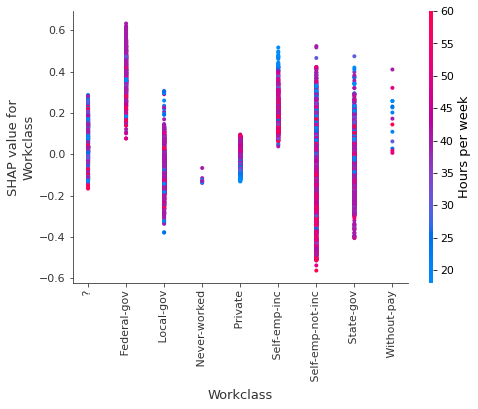

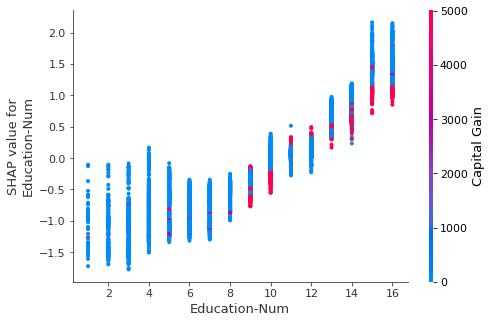

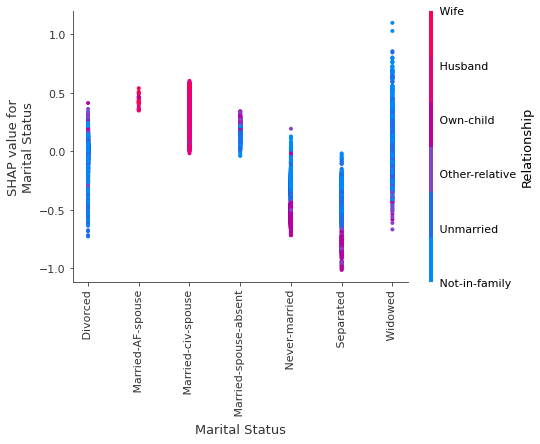

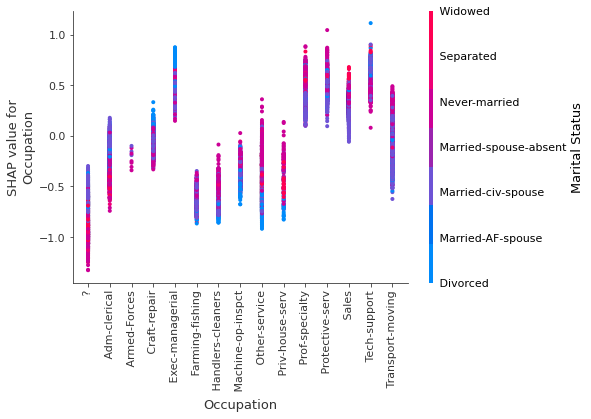

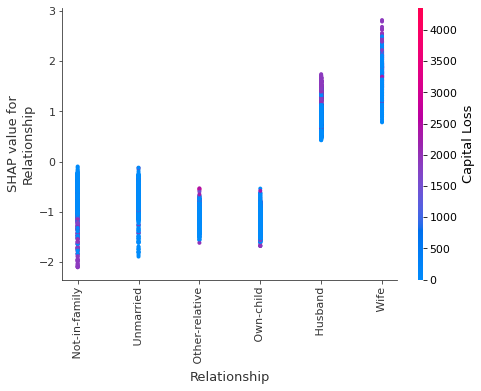

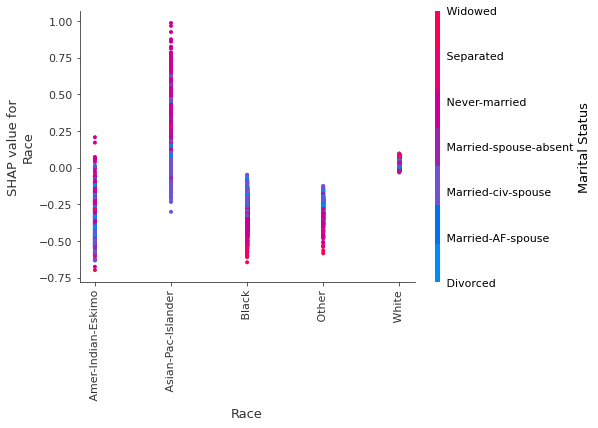

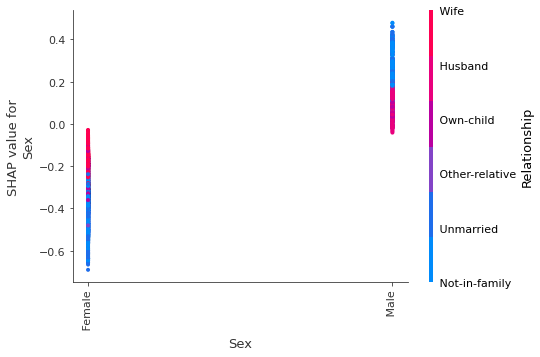

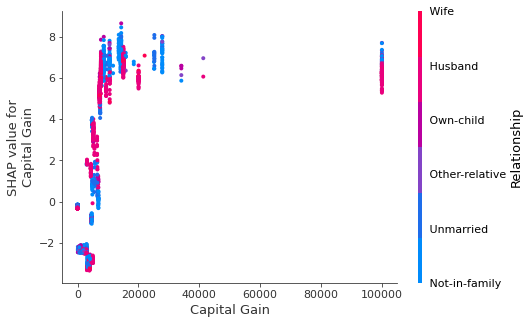

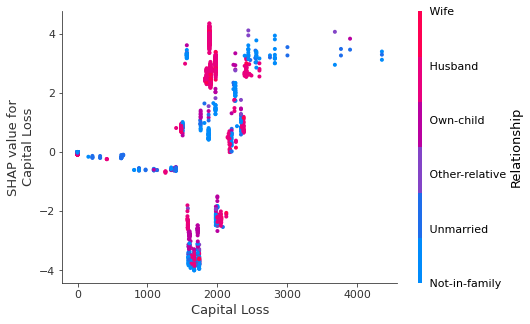

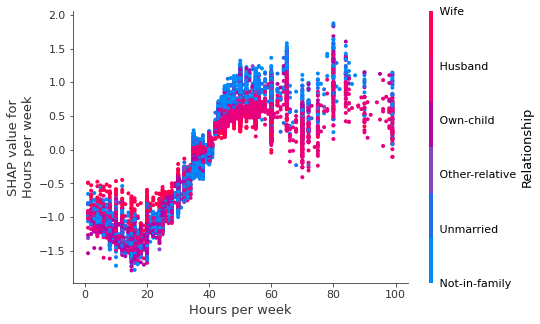

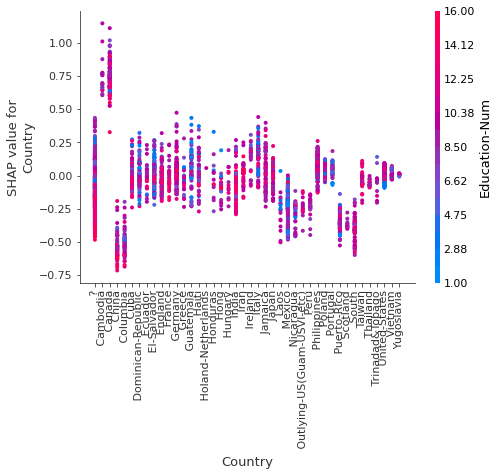

In [18]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X, display_features=X_display)

### Train a model with only two leaves per tree and hence no interaction terms between features

Forcing the model to have no interaction terms means the effect of a feature on the outcome does not depend on the value of any other feature. This is reflected in the SHAP dependence plots below as no vertical spread. A vertical spread reflects that a single value of a feature can have different effects on the model output depending on the context of the other features present for an individual. However, for models without interaction terms, a feature always has the same impact regardless of what other attributes an individual may have.

One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.

In [19]:
params = {
    "max_bin": 512,
    "learning_rate": 0.1,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 2,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model_ind = lgb.train(params, d_train, 20000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
[1000]	valid_0's binary_logloss: 0.29538
[2000]	valid_0's binary_logloss: 0.289283
[3000]	valid_0's binary_logloss: 0.286626
[4000]	valid_0's binary_logloss: 0.284987
[5000]	valid_0's binary_logloss: 0.283784
[6000]	valid_0's binary_logloss: 0.282935
[7000]	valid_0's binary_logloss: 0.28226
[8000]	valid_0's binary_logloss: 0.281723
Early stopping, best iteration is:
[7958]	valid_0's binary_logloss: 0.281714


In [20]:
shap_values_ind = shap.TreeExplainer(model_ind).shap_values(X)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Note that the interaction color bars below are meaningless for this model because it has no interactions.

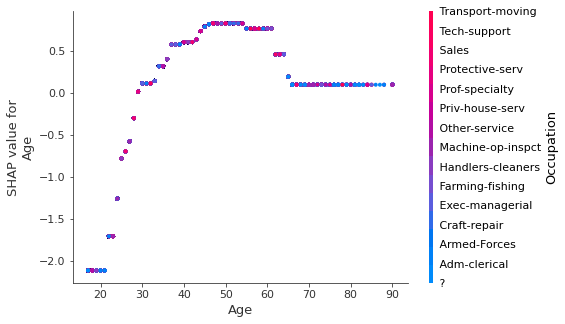

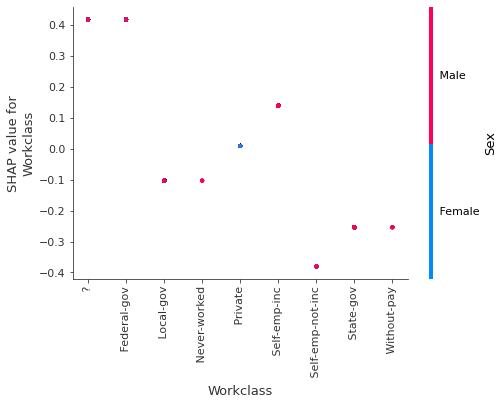

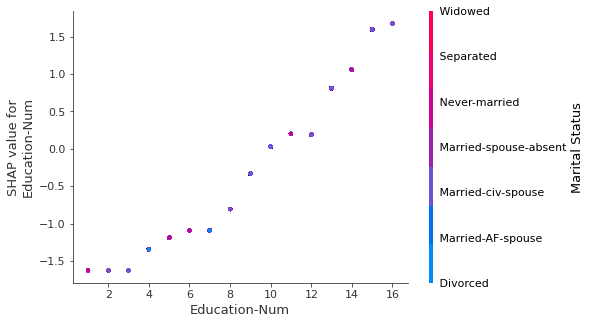

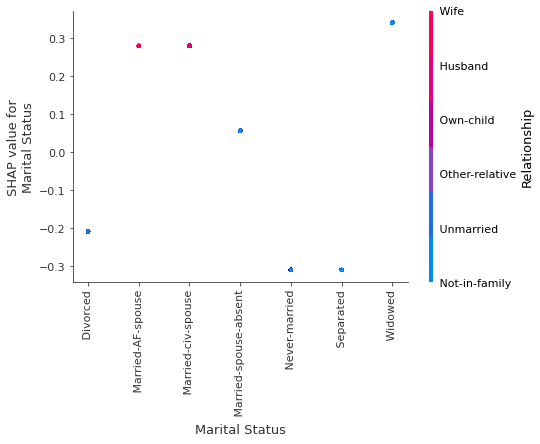

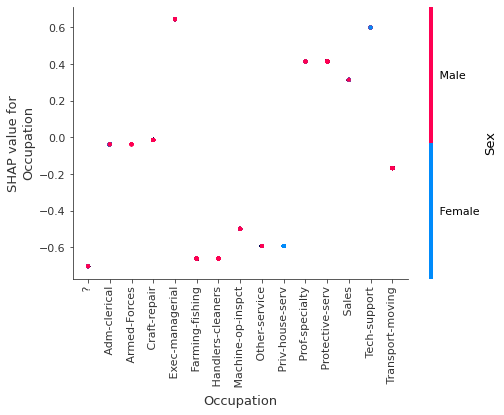

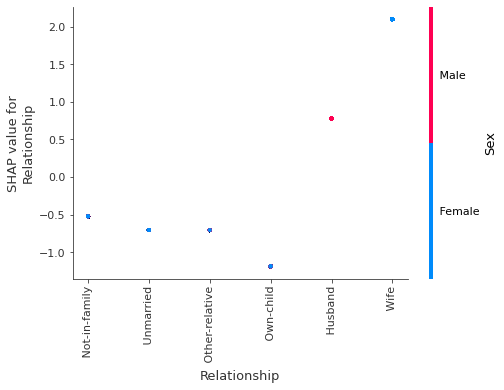

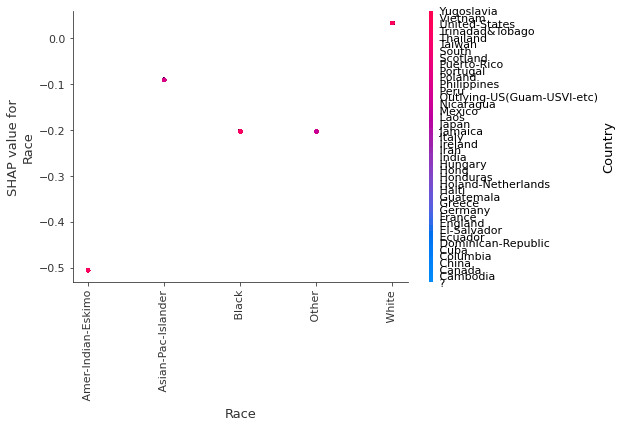

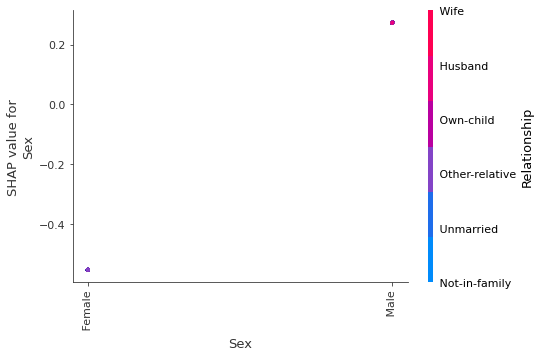

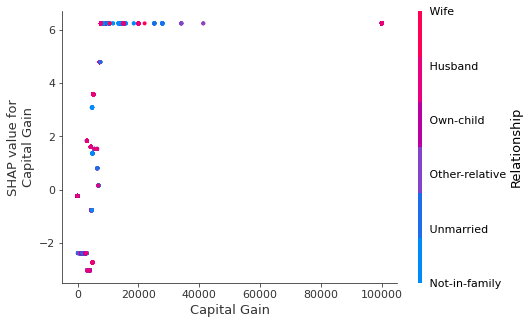

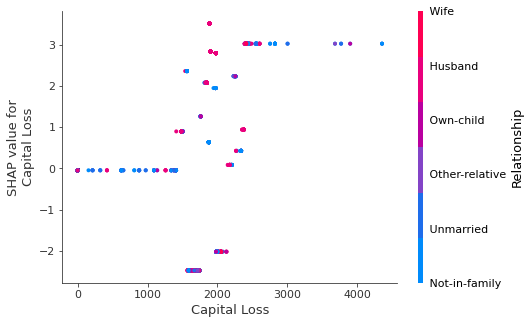

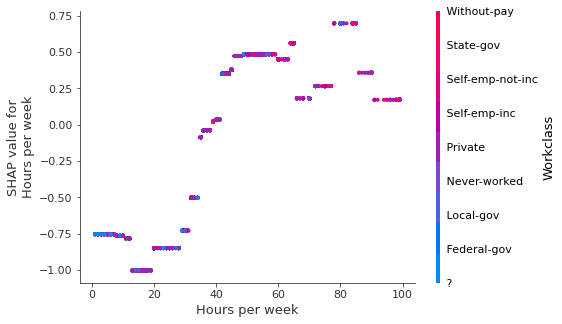

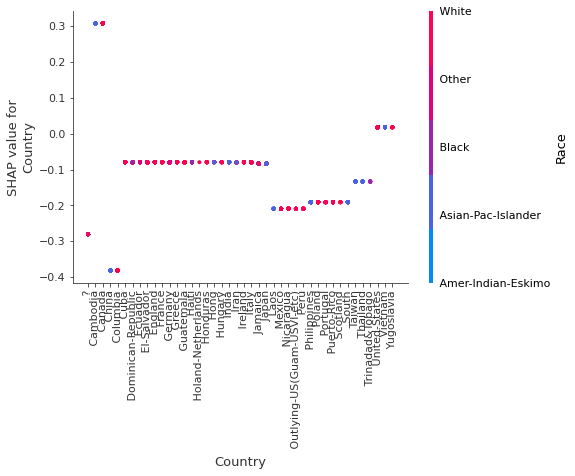

In [21]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values_ind[1], X, display_features=X_display)

## Compare explanations with different dataset

In [22]:
y_df = pd.DataFrame(y, columns=["y"])
pd.DataFrame(y_df.y.value_counts(normalize=True))

y
False  0.75919
True   0.24081

In [209]:
def calc_explanation(model, background_data, instance, model_output="raw"):
    explainer = shap.TreeExplainer(model, background_data, model_output)
    explanation = explainer(instance)
    shap_values = explanation.values
    expected_value = explanation.base_values
    return explanation

###  Using no explicitly background data (infered from the Trees)

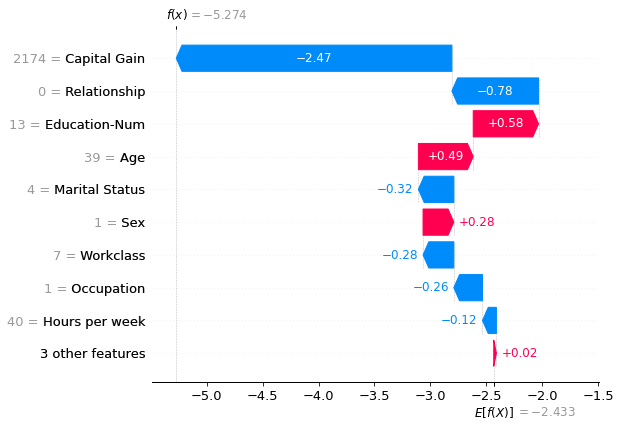

In [210]:
explanation = calc_explanation(model, None, X.iloc[0:1])
shap.waterfall_plot(explanation[0,:,1])

###  Using the entire dataset as background data

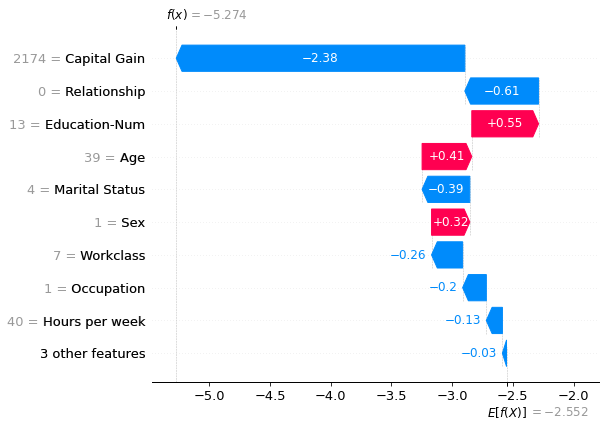

In [211]:
explanation = calc_explanation(model, X, X.iloc[0:1])
shap.waterfall_plot(explanation[0])

###  Using only the positive instances

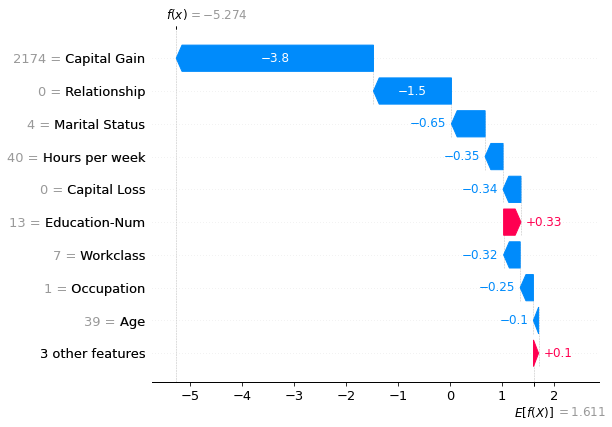

In [212]:
explanation = calc_explanation(model, X[y_df.y == True], X.iloc[0:1])
shap.waterfall_plot(explanation[0])

###  Using only the negative instances

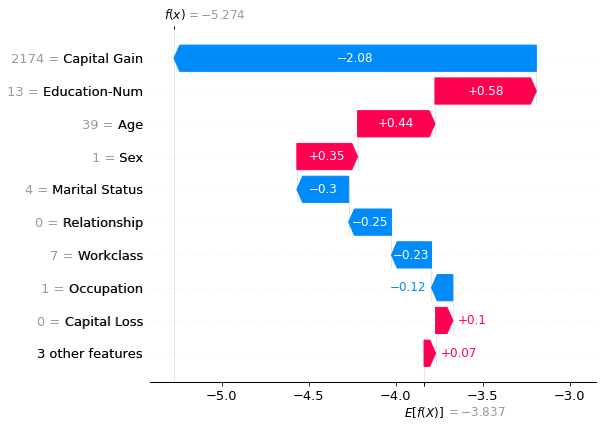

In [213]:
explanation = calc_explanation(model, X[y_df.y == False], X.iloc[0:1])
shap.waterfall_plot(explanation[0])